# Final Comprehensive Benchmark

**Goal**: Determine the final Champion Model for the MLOps Pipeline.
**Approach**: Test 10 Classifiers using **Label Encoding** and **Sample Weights** (to handle imbalance).
**Reference**: Replicates the high-performing Kaggle approach (F1 ~0.74-0.80).

## 1. Imports & Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import mlflow
import mlflow.sklearn
import mlflow.lightgbm
import mlflow.catboost

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# Models
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

warnings.filterwarnings("ignore")
%matplotlib inline

# MLflow Setup
mlflow.set_tracking_uri("file:../mlruns")
mlflow.set_experiment("Churn_Prediction_Final_Benchmark")

<Experiment: artifact_location='file:d:/MLOPS PROJECT CHURN PRED/experiment/../mlruns/257267200039095969', creation_time=1767699384391, experiment_id='257267200039095969', last_update_time=1767699384391, lifecycle_stage='active', name='Churn_Prediction_Final_Benchmark', tags={}>

## 2. Data Loading & Preprocessing

In [3]:
def load_and_process_data(path):
    df = pd.read_csv(path)
    
    # Drop ID
    if 'customer_id' in df.columns:
        df.drop("customer_id", axis=1, inplace=True)

    # Fill NA (Simple approach for Tree Models)
    # Categorical -> "Unknown", Numeric -> Median (if any)
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna("Unknown")
        else:
            if df[col].isnull().sum() > 0:
                df[col] = df[col].fillna(df[col].median())
    
    # Label Encoding
    le = LabelEncoder()
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = le.fit_transform(df[col])
            
    return df

## 3. Train-Test Split & Sample Weights

In [4]:
df = load_and_process_data('../customer_churn_dataset/customer_churn_dataset.csv')

X = df.drop('churn', axis=1)
y = df['churn']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Compute Sample Weights (Unified Strategy)
# This gives higher weight to the minority class (Churn=1) rows during training
train_sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

print("Train Shape:", X_train.shape)
print("Sample Weights Shape:", train_sample_weights.shape)

Train Shape: (16000, 9)
Sample Weights Shape: (16000,)


## 4. Define Models

In [5]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Extra Trees": ExtraTreesClassifier(),
    "Logistic Regression": LogisticRegression(),
    "SVC": SVC(),
    "Naive Bayes": MultinomialNB(),
    "XGBoost": XGBClassifier(verbosity=0),
    "LightGBM": LGBMClassifier(verbosity=-1),
    "CatBoost": CatBoostClassifier(verbose=0)
}

## 5. Training Loop with MLflow Tracking

In [6]:
results = []
confusion_matrices = {}

for name, model in models.items():
    with mlflow.start_run(run_name=name):
        print(f"Training {name}...")
        
        # FIT with sample_weight
        # Note: Not all sklearn models accept sample_weight in fit (e.g. some NBs might differ, but MultinomialNB does)
        # We try-except to handle edge cases if any models don't support it standardly
        try:
            model.fit(X_train, y_train, sample_weight=train_sample_weights)
        except TypeError:
             # Fallback for models that might not support sample_weight (KNN, etc if added)
            model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        
        # Metrics
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        # Store Results
        results.append({"Model": name, "Accuracy": acc, "F1_Score": f1})
        confusion_matrices[name] = cm
        
        # MLflow Log
        mlflow.log_param("model_name", name)
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("f1_score", f1)
        
        # Log Model Artifact
        if name == "LightGBM":
            mlflow.lightgbm.log_model(model, name=name.replace(" ", "_"))
        elif name == "CatBoost":
            mlflow.catboost.log_model(model, name=name.replace(" ", "_"))
        else:
            mlflow.sklearn.log_model(model, name=name.replace(" ", "_"))

        print(f"Completed {name}. Acc: {acc:.2%}, F1: {f1:.4f}")
        print(classification_report(y_test, y_pred))

Training Random Forest...
Completed Random Forest. Acc: 83.88%, F1: 0.7340
              precision    recall  f1-score   support

           0       0.84      0.94      0.88      2631
           1       0.84      0.65      0.73      1369

    accuracy                           0.84      4000
   macro avg       0.84      0.79      0.81      4000
weighted avg       0.84      0.84      0.83      4000

Training AdaBoost...
Completed AdaBoost. Acc: 76.02%, F1: 0.6741
              precision    recall  f1-score   support

           0       0.84      0.78      0.81      2631
           1       0.63      0.72      0.67      1369

    accuracy                           0.76      4000
   macro avg       0.74      0.75      0.74      4000
weighted avg       0.77      0.76      0.76      4000

Training Gradient Boosting...
Completed Gradient Boosting. Acc: 82.53%, F1: 0.7229
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      2631
           1  

## 6. Visualization & Comparison

                 Model  Accuracy  F1_Score
8             LightGBM   0.84400  0.742786
9             CatBoost   0.84200  0.739918
0        Random Forest   0.83875  0.734021
7              XGBoost   0.82750  0.726408
2    Gradient Boosting   0.82525  0.722949
3          Extra Trees   0.81550  0.700000
1             AdaBoost   0.76025  0.674142
4  Logistic Regression   0.70150  0.624528
6          Naive Bayes   0.60950  0.516708
5                  SVC   0.60625  0.470944


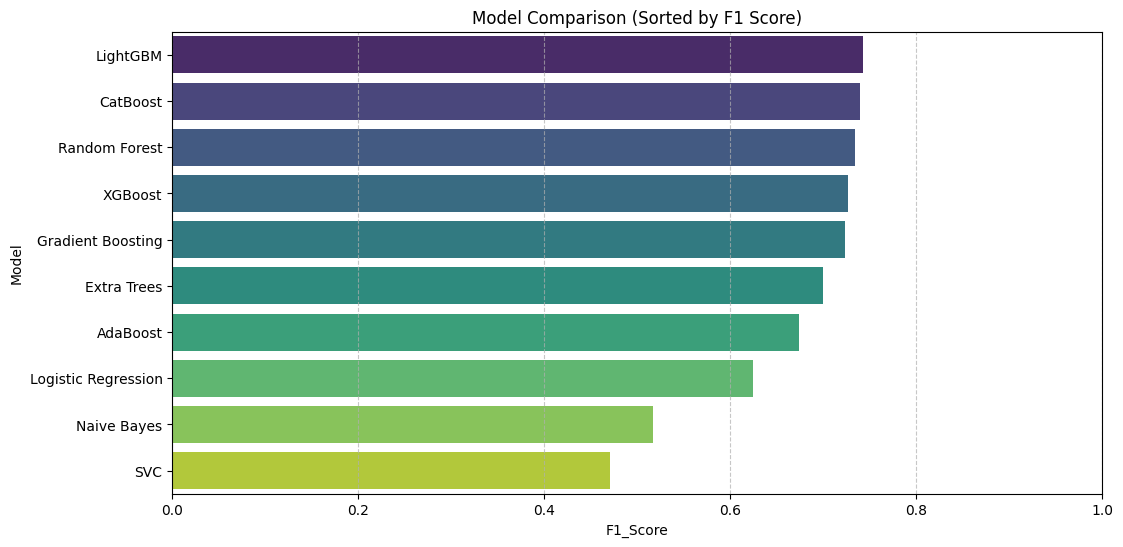

In [7]:
# Create DataFrame
df_res = pd.DataFrame(results).sort_values("F1_Score", ascending=False)
print(df_res)

# Bar Plot
plt.figure(figsize=(12, 6))
sns.barplot(x="F1_Score", y="Model", data=df_res, palette="viridis")
plt.title("Model Comparison (Sorted by F1 Score)")
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

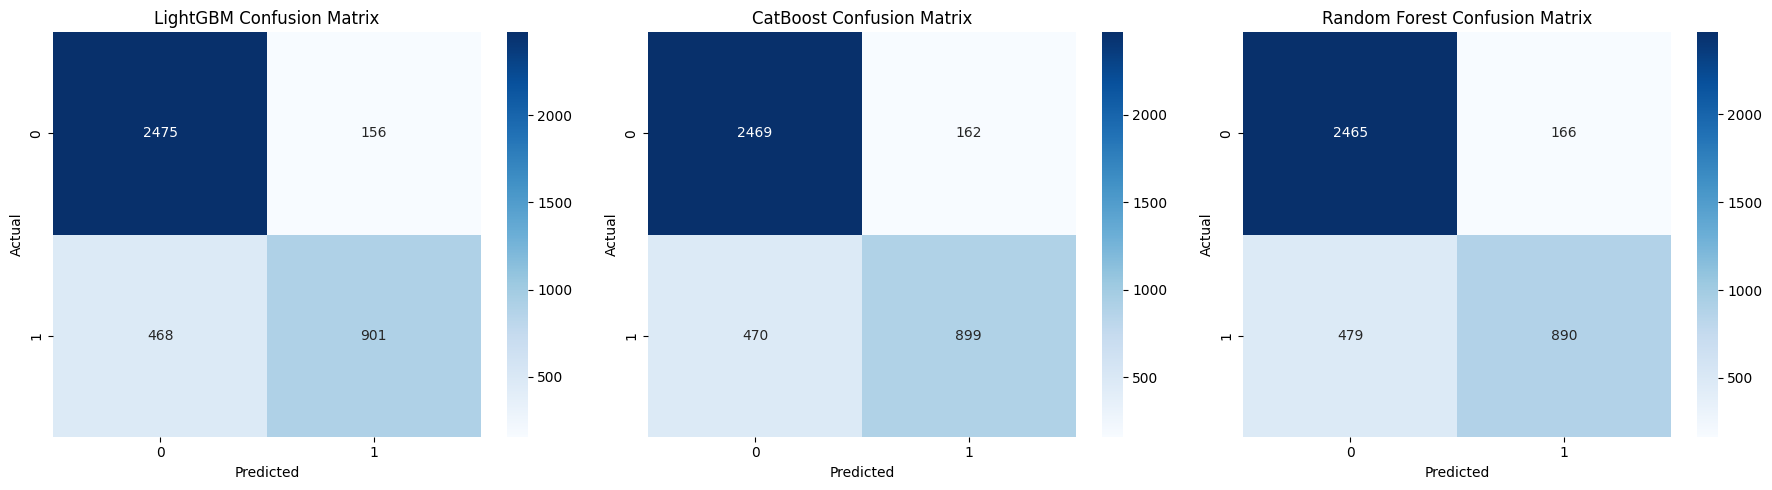

In [8]:
# Plot Confusion Matrices for Top 3 Models
top_3 = df_res["Model"].head(3).values

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, model_name in enumerate(top_3):
    sns.heatmap(confusion_matrices[model_name], annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f"{model_name} Confusion Matrix")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.tight_layout()
plt.show()